Install necessary python libraries

In [1]:
import sys
!{sys.executable} -m pip install GitPython matplotlib wand fpdf

  Using cached GitPython-3.1.29-py3-none-any.whl (182 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.2/11.2 MB 26.1 MB/s eta 0:00:00m eta 0:00:010:0101
  Using cached Wand-0.6.10-py2.py3-none-any.whl (142 kB)
  Using cached fpdf-1.7.2-py2.py3-none-any.whl
  Using cached gitdb-4.0.9-py3-none-any.whl (63 kB)
  Using cached fonttools-4.38.0-py3-none-any.whl (965 kB)
  Using cached numpy-1.21.6-cp37-cp37m-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (15.7 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 30.8 MB/s eta 0:00:00m eta 0:00:01
  Using cached cycler-0.11.0-py3-none-any.whl (6.4 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 27.0 MB/s eta 0:00:0031m30.9 MB/s eta 0:00:01
  Using cached smmap-5.0.0-py3-none-any.whl (24 kB)


Clone MetOcean storm_surge github repository to /tmp folder

In [6]:
from git import Repo
repo = Repo.clone_from("git@github.com:metocean/storm_surge.git", "/tmp/storm_surge", branch="linz_processing")


Clone and install Calypso Science Toto python library

In [5]:
# Repo.clone_from("git@github.com:calypso-science/Toto.git", "/tmp/Toto")
from git import Repo
Repo.clone_from("git@github.com:calypso-science/Toto.git", "/tmp/Toto", branch="storm_surge_project")
!{sys.executable} -m pip install --no-cache-dir -r /tmp/Toto/requirements.txt
!{sys.executable} -m pip install -e /tmp/Toto

  Cloning https://github.com/python-windrose/windrose to /tmp/pip-req-build-t6pv3iz3
  Running command git clone --filter=blob:none --quiet https://github.com/python-windrose/windrose /tmp/pip-req-build-t6pv3iz3
  Resolved https://github.com/python-windrose/windrose to commit 7342238361b28943063b9b9669cb47bc81f568f2
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Cloning https://github.com/wesleybowman/UTide.git to /tmp/pip-req-build-elxdzph6
  Running command git clone --filter=blob:none --quiet https://github.com/wesleybowman/UTide.git /tmp/pip-req-build-elxdzph6
  Resolved https://github.com/wesleybowman/UTide.git to commit b2bd8367e132dc896c4a96ff633aeefb45b0a87c
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.1/40.1 kB 124.8 MB/s eta 0:00:00
  Preparing metadat

Failed to build pysqlite3
  Running setup.py install for pysqlite3 ... done
Obtaining file:///tmp/Toto
  Preparing metadata (setup.py) ... done
  Running setup.py develop for toto


First we read LINZ sea level data.

In [1]:
import sys
sys.path.append('/tmp/storm_surge/storm_surge/timeseries_processing/linz_waterlevel')
import LINZ

filein = '/tmp/linz/raw/AUCT/AUCT_raw.nc'
dfraw, lon, lat = LINZ.read_linz(filein, None)

Reading: /tmp/linz/raw/AUCT/AUCT_raw.nc
Processing water levels for sensor 40
Assuming datum height equal to time average of water levels = 5.1441 m. No sensor offset drifting corrections applied.
Processing water levels for sensor 41
Assuming datum height equal to time average of water levels = 5.2652 m. No sensor offset drifting corrections applied.


Now we select which sensor we want to use.

In [2]:
%matplotlib qt
from core_routines.check import plot_graph as select_sensor
import copy
import os
import matplotlib.pyplot as plt

tmpfolder = '/tmp'
df0 = copy.deepcopy(dfraw)

answer = select_sensor([dfraw, dfraw], \
                       ['elev40', 'elev41'], \
                       ['Click on this graph to choose sensor: 40','41'],
                       save=os.path.join(tmpfolder, 'raw_data.png'),
                       eventname='choose')

# print('Waiting 20 s for user interaction')
# plt.pause(20)
# print('Closing figure')
# plt.close('all')
print('Waiting for button press')
plt.waitforbuttonpress()
print('Continuing')

## switch to right dataframe
if answer['axes'] == '41':
    sensor = '41'
    del df0['elev40']
else:
    sensor = '40'
    del df0['elev41']

print(f'Switching to sensor {sensor}')
df0.rename(columns={f'elev{sensor}':'elev'}, inplace=True)

del df0['time']
        

Waiting for button press
Continuing
Switching to sensor 40


Clean the data automatically.

In [3]:
from core_routines.toolbox import clean_linz

phasespace3d = True
despike = True
abs_threshold = 3
detrend_btw_gap = False

df1 = clean_linz(copy.deepcopy(df0),
                 dt=60,
                 phasespace3d=phasespace3d,
                 despike=despike,
                 abs_threshold=abs_threshold,
                 detrend_btw_gap=detrend_btw_gap)

#df1 = clean_linz(copy.deepcopy(df0), dt=60)



	Fill gap
	Resample to hourly
	Remove spike with phasespace3d
	Remove spike with abs threshold (if value exceeds)


Clean the data manually.

In [4]:
from core_routines.check import plot_graph as clean_manually

answer = clean_manually([df0,df1],['elev','detrend'],['Raw','Filter'],save=None,eventname='clean')


In [5]:
from core_routines.toolbox import delete_manually
from matplotlib.dates import num2date

deleted_time = {}
if 'delete' in answer:
    df1['clean'] = delete_manually(df1['detrend'], answer['delete'])

    for i, time in enumerate(answer['delete']):
        deleted_time[str(i+1)] = 'From %s to %s' % (num2date(time[0]).strftime('%Y-%m-%d %H:00'),num2date(time[1]).strftime('%Y-%m-%d %H:00'))

else:
    df1['clean'] = df1['detrend']

df = df1['clean'].copy().to_frame()
df.rename(columns={'clean':'elev'},inplace=True)


Now we do the time series analysis itself, spliting the sea level in different signals to get the storm surge.

In [6]:
from core_routines.toolbox import do_analysis, store_data_as_netcdf

cutoff = 30
folderout = '/tmp/linz/processed/AUCT/'
fileout = os.path.join(folderout, 'AUCT_processed.nc')

df = do_analysis(df['elev'], lat, cutoff=cutoff)

# Save the new dataset into a NetCDF
store_data_as_netcdf(df, lon, lat, fileout)


	Storing NaNs position
	Detrending
	Tidal analysis
{'trend': False, 'constit': 'auto', 'method': 'ols', 'conf_int': 'linear', 'Rayleigh_min': 2}
solve: matrix prep ... solution ... done.
prep/calcs ... done.
	Monthly mean filtering
	Storm surge filtering
	Skew surge filtering
prep/calcs ... done.


In [8]:
# save a pdf with the parameters used and the different steps taken

pdflog = os.path.join(folderout, 'AUCT_log.pdf')
prefix = 'AUCT'

LINZ.save_pdf(df, df1, pdflog, prefix, filein, fileout, cutoff, sensor, tmpfolder, \
         phasespace3d, despike, abs_threshold, detrend_btw_gap, \
         deleted_time, folderout)

Saving log to /tmp/linz/processed/AUCT/AUCT_log.pdf


The resulting pdf log showing all the processing steps performed with the sea level data is shown bellow:

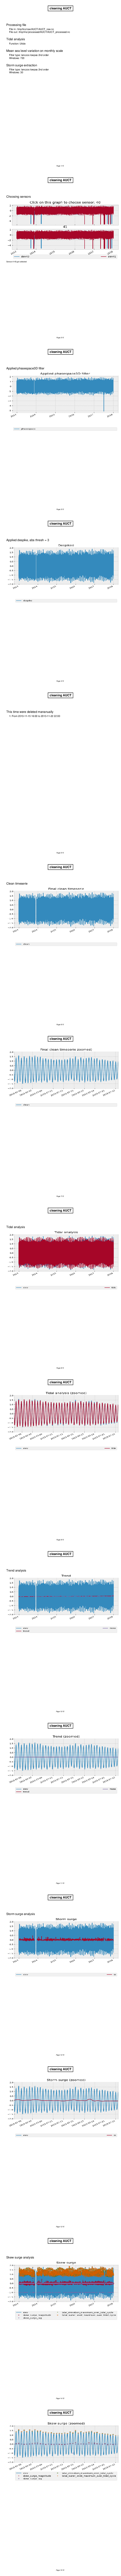

In [9]:
from wand.image import Image

imageFromPdf = Image(filename='/tmp/linz/processed/AUCT/AUCT_log.pdf')
pages = len(imageFromPdf.sequence)  

image = Image(  
  width=imageFromPdf.width,  
  height=imageFromPdf.height * pages  
)  
for i in range(pages):  
  image.composite(  
  imageFromPdf.sequence[i],  
  top=imageFromPdf.height * i,  
  left=0  
)  
image.format="png"  
image 
